In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import cartopy.feature as cfeature
import os
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import xesmf as xe

In [171]:
home_path = os.path.expanduser("~")

path = '/DataFiles'
path2 = '/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - MacBook Air/Python/Ice Cores/data/model/ccsm4_last_millenium'

racmo = xr.open_dataset(home_path + path + "/smb_monthlyS_ANT27_ERA5-3H_RACMO2.3p2_197901_202212.nc")
mask = xr.open_dataset(home_path + path + "/TotIS_RACMO_ANT27_IMBIE2.nc")

In [173]:
def compute_2d_bounds(arr):
    """
    Compute approximate 2D cell corner bounds for a 2D array.
    arr: 2D array of lat or lon with shape (ny, nx)
    Returns: 2D array of bounds with shape (ny+1, nx+1)

    This function is used when constructing an xESMF grid, which requires
    cell-corner coordinates rather than cell centers. The bounds are 
    approximated by averaging adjacent grid cells and extrapolating at edges.
    """
    ny, nx = arr.shape

    # Compute interior midpoints (unused in final calculation, but preserves idea)
    b = 0.5 * (arr[:-1, :-1] + arr[1:, 1:])

    # Allocate full bounds array (one larger in each dimension)
    b_full = np.zeros((ny+1, nx+1))

    # Fill interior bounds using 4-cell average (standard finite-difference midpoint)
    b_full[1:-1, 1:-1] = 0.25 * (arr[:-1, :-1] + arr[1:, :-1] + arr[:-1, 1:] + arr[1:, 1:])

    # Top/bottom edges: extrapolate one half-grid outside domain
    b_full[0, 1:-1] = arr[0, :-1] - 0.5 * (arr[1, :-1] - arr[0, :-1])
    b_full[-1, 1:-1] = arr[-1, :-1] + 0.5 * (arr[-1, :-1] - arr[-2, :-1])

    # Left/right edges: similar 1D extrapolation in x
    b_full[1:-1, 0] = arr[:-1, 0] - 0.5 * (arr[:-1, 1] - arr[:-1, 0])
    b_full[1:-1, -1] = arr[:-1, -1] + 0.5 * (arr[:-1, -1] - arr[:-1, -2])

    # Fill corners by copying nearest interior bounds (simple but sufficient)
    b_full[0, 0] = b_full[1, 1]
    b_full[0, -1] = b_full[1, -2]
    b_full[-1, 0] = b_full[-2, 1]
    b_full[-1, -1] = b_full[-2, -2]

    return b_full

# Extract lat/lon from RACMO regridded Antarctic domain (2D arrays of cell centers)
lat = racmo["lat"].values
lon = racmo["lon"].values

# Compute corner bounds needed for conservative regridding in xESMF
lat_b = compute_2d_bounds(lat)
lon_b = compute_2d_bounds(lon)

# Build an xarray dataset describing the grid geometry for xESMF
grid_ds = xr.Dataset(
    {
        "lat": (["y", "x"], lat),
        "lon": (["y", "x"], lon),
        "lat_b": (["y_b", "x_b"], lat_b),
        "lon_b": (["y_b", "x_b"], lon_b),
    }
)

print(grid_ds)

# Compute grid-cell surface area from lat/lon using xESMF utilities (km²)
cellArea = xe.util.cell_area(grid_ds, earth_radius=6371.0)
threshold = 800  # smoothing threshold: cap extreme large cells (>800 km²)

# Copy cell-area array so modifications do not affect original
cellArea_fixed = cellArea.copy()

# Smooth cell-area anomalies row-by-row
for i in range(cellArea_fixed.shape[0]):
    # Compute row mean of all cells that are below threshold
    row_mean = cellArea_fixed[i, :].where(cellArea_fixed[i, :] <= threshold).mean()
    # Replace oversized cells with the representative row mean
    cellArea_fixed[i, :] = xr.where(cellArea_fixed[i, :] > threshold, row_mean, cellArea_fixed[i, :])

# RACMO SMB field (kg m⁻² per month) → squeeze height dimension
smb = racmo["smb"].squeeze("height")

# Aggregate SMB to annual totals (kg m⁻² yr⁻¹)
smb_ann = smb.groupby("time.year").sum(dim="time").sel(year=slice(1979, 2022))

# Reload lat/lon again (same arrays), ensuring consistent shape names
lat = racmo["lat"].values
lon = racmo["lon"].values

# Convert smoothed cell area (km²) into xarray DataArray (for broadcasting)
cell_area_da = xr.DataArray(cellArea_fixed, dims=("rlat", "rlon"))

# Convert SMB flux into total annual mass per cell (Gt contribution computed later)
smb_mass_ann = smb_ann * cell_area_da * 1_000_000  # km² → m² using 1e6

# Spatial integral of SMB over Antarctica (Gt yr⁻¹)
antarctic_smb_Gt_ann = smb_mass_ann.sum(dim=("rlat", "rlon")) / 1e12

# --- 1️⃣  Prepare core inputs ---

# Annual SMB field again (kg m⁻² yr⁻¹)
smb = racmo["smb"].squeeze("height")
smb_ann = smb.groupby("time.year").sum(dim="time").sel(year=slice(1979, 2022))

# Convert cell area from km² → m² for proper SMB mass conversion
cell_area_m2 = cellArea_fixed * 1e6
cell_area_da = xr.DataArray(cell_area_m2, dims=("rlat", "rlon"))

# Drainage basin mask, identifying grounded-ice hydrological basins (e.g., IMBIE)
basin_mask = mask["GroundedIce"]

# Replace NaNs with 0 so the “non-basin” category is explicit
basin_mask = basin_mask.where(~np.isnan(basin_mask), 0)

# --- 2️⃣  Compute SMB mass (kg) per grid cell, each year ---

smb_mass_ann = smb_ann * cell_area_da

# --- 3️⃣  Flatten for vectorized grouped summation over basins ---

nlat, nlon = basin_mask.shape
basin_flat = basin_mask.values.reshape(nlat * nlon)

# Valid grounded-ice cells only
valid_mask = (basin_flat > 0) & np.isfinite(basin_flat)
basin_ids = basin_flat[valid_mask].astype(int)

# Prepare output DataFrame: index=years, columns=basin IDs
years = smb_ann["year"].values
basin_ids_unique = np.unique(basin_ids)
smb_per_basin_Gt = pd.DataFrame(index=years, columns=basin_ids_unique)

# --- 4️⃣  Loop over years: compute basin-summed SMB in gigatonnes ---

for i, yr in enumerate(years):
    # Flatten annual SMB mass for this year
    smb_yr = smb_mass_ann.sel(year=yr).values.reshape(nlat * nlon)

    # Extract only grounded-ice cells
    smb_valid = smb_yr[valid_mask]

    # Organize into a DataFrame for easy groupby aggregation
    df = pd.DataFrame({"basin": basin_ids, "mass_kg": smb_valid})

    # Sum by basin and convert to Gt
    smb_sum = df.groupby("basin")["mass_kg"].sum() / 1e12
    smb_per_basin_Gt.loc[yr, smb_sum.index] = smb_sum.values

# --- 5️⃣  Finished computing SMB per basin (Gt yr⁻¹) ---
# print(smb_per_basin_Gt)


<xarray.Dataset> Size: 2MB
Dimensions:  (y: 240, x: 262, y_b: 241, x_b: 263)
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    lat      (y, x) float64 503kB -46.75 -46.92 -47.09 ... -47.42 -47.24 -47.07
    lon      (y, x) float64 503kB -126.9 -127.1 -127.3 ... 52.84 53.03 53.23
    lat_b    (y_b, x_b) float64 507kB -46.91 -46.67 -46.84 ... -47.17 -47.24
    lon_b    (y_b, x_b) float64 507kB -126.8 -127.0 -127.2 ... 52.69 52.89 53.28


In [174]:
# Compute annual SMB time series from monthly RACMO fields
# (kg m⁻² yr⁻¹). Collapse height dimension, group by year, sum over months.
smb_ann = (
    racmo["smb"]
    .squeeze("height")
    .groupby("time.year")
    .sum(dim="time")
    .sel(year=slice(1979, 2022))
)

# --- 2️⃣ Define basin-based SMB totals (Gt/yr) ---
# Aggregate drainage basins into large-scale Antarctic regions:
# AIS  = Entire Antarctic Ice Sheet
# WAIS = West Antarctic Ice Sheet (selected basins)
# EAIS = East Antarctic Ice Sheet  (selected basins)
# AP   = Antarctic Peninsula       (selected basins)
ais_smb  = smb_per_basin_Gt.sum(axis=1)
wais_smb = smb_per_basin_Gt[[3,7,8,9,10]].sum(axis=1)
eais_smb = smb_per_basin_Gt[[1,2,11,12,13,14,15,16,17,18]].sum(axis=1)
ap_smb   = smb_per_basin_Gt[[4,5,6]].sum(axis=1)

# --- 3️⃣ Normalize each series (convert to standardized anomalies) ---
# Subtract mean and divide by standard deviation.
def normalize(series):
    return (series - series.mean()) / series.std()

ais_smb_anom  = normalize(ais_smb)
wais_smb_anom = normalize(wais_smb)
eais_smb_anom = normalize(eais_smb)
ap_smb_anom   = normalize(ap_smb)

# --- 4️⃣ Convert each anomaly series to an xarray DataArray ---
# Ensures compatibility with xarray operations and broadcasting.
def to_xr(series, smb_ann):
    return xr.DataArray(
        series.values.astype(float),
        dims=["year"],
        coords={"year": smb_ann["year"].values}
    )

ais_smb_da  = to_xr(ais_smb_anom, smb_ann)
wais_smb_da = to_xr(wais_smb_anom, smb_ann)
eais_smb_da = to_xr(eais_smb_anom, smb_ann)
ap_smb_da   = to_xr(ap_smb_anom, smb_ann)

# --- 5️⃣ Robust correlation function ---
# Handles missing values; returns Pearson correlation between SMB at each grid cell
# and a regional SMB anomaly series.
def corr_func(smb_ts, region_ts):
    smb_ts = np.asarray(smb_ts, dtype=float)
    region_ts = np.asarray(region_ts, dtype=float)
    mask = np.isfinite(smb_ts) & np.isfinite(region_ts)
    if mask.sum() < 2:  # insufficient valid points
        return np.nan
    return np.corrcoef(smb_ts[mask], region_ts[mask])[0, 1]

# --- 6️⃣ Compute spatial correlation map for a given region ---
# Uses xarray’s apply_ufunc to compute correlation for each grid cell
# across the time dimension ("year").
def compute_corr_map(region_da):
    return xr.apply_ufunc(
        corr_func,
        smb_ann, region_da,
        input_core_dims=[["year"], ["year"]],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float]
    )

# Correlation maps showing spatial patterns of SMB → regional SMB linkages
ais_corr_map  = compute_corr_map(ais_smb_da)
wais_corr_map = compute_corr_map(wais_smb_da)
eais_corr_map = compute_corr_map(eais_smb_da)
ap_corr_map   = compute_corr_map(ap_smb_da)

# Convert basin SMB totals back to clean float arrays (Gt/yr)
# Useful for regressions, EOFs, or assimilation later in the workflow.
ais_accum_racmo  = np.asarray(pd.to_numeric(ais_smb,  errors='coerce'), dtype=float)
wais_accum_racmo = np.asarray(pd.to_numeric(wais_smb, errors='coerce'), dtype=float)
eais_accum_racmo = np.asarray(pd.to_numeric(eais_smb, errors='coerce'), dtype=float)
ap_accum_racmo   = np.asarray(pd.to_numeric(ap_smb,   errors='coerce'), dtype=float)

# Corresponding year axis covering 1979–2022 inclusive
years = np.arange(1979, 2023)


/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_80726/502293446.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nlat, nlon = mask.dims["lat"], mask.dims["lon"]


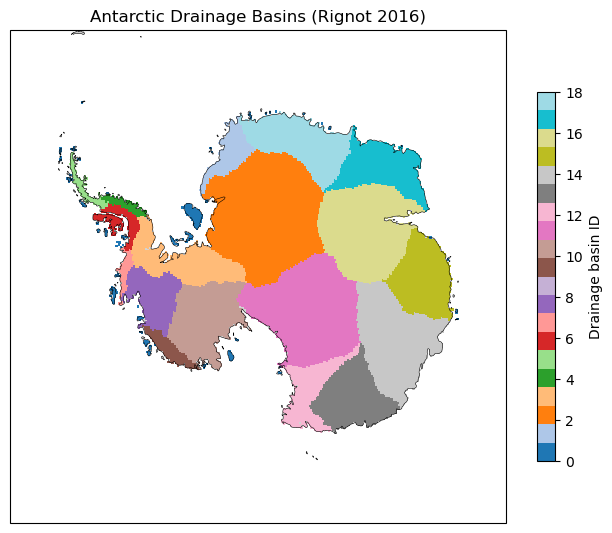

In [175]:
# Extract coordinate arrays
# The basin mask stores 2D lat/lon grids in its attributes ("lat2d", "lon2d").
# These must be manually pulled out because the dataset does not expose them as coords.
lat_attr = np.array(mask.GroundedIce.attrs["lat2d"])
lon_attr = np.array(mask.GroundedIce.attrs["lon2d"])

# Reshape to 2D
# The lat/lon arrays are stored flat; reshape them to match the mask grid dimensions.
nlat, nlon = mask.dims["lat"], mask.dims["lon"]
lats2d = lat_attr.reshape(nlat, nlon)
lons2d = lon_attr.reshape(nlat, nlon)

# Attach as coordinates
# Add the 2D lat/lon fields as proper xarray coordinates on the basin mask,
# enabling georeferenced plotting (e.g., with cartopy).
basins = mask["GroundedIce"].copy()
basins = basins.assign_coords(
    lat=(("lat", "lon"), lats2d),
    lon=(("lat", "lon"), lons2d)
)

# Define map projections
# Use Antarctic stereographic projection for plotting, with PlateCarree for data input.
proj = ccrs.SouthPolarStereo()
data_crs = ccrs.PlateCarree()

# Create figure and axis with polar stereographic projection
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': proj})
ax.set_extent([-180, 180, -90, -60], crs=data_crs)

# Add coastlines and land shading for geographical context
ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Filled contour plot of basin IDs
# pcolormesh uses the 2D lat/lon coordinates supplied above.
im = ax.pcolormesh(
    basins.lon, basins.lat, basins,
    transform=data_crs,
    cmap='tab20'
)

# Add colorbar identifying drainage basin numbers
plt.colorbar(im, ax=ax, shrink=0.6, label="Drainage basin ID")

# Title and display
ax.set_title("Antarctic Drainage Basins (Rignot 2016)", fontsize=12)
plt.show()


/opt/anaconda3/envs/xesmf-env/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


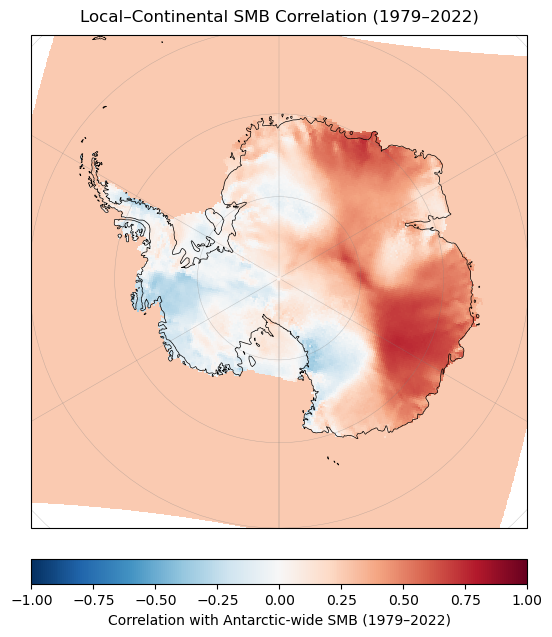

In [176]:
# Define projection
# Use a South Polar Stereographic projection for proper representation of Antarctica.
proj = ccrs.SouthPolarStereo()

# Create figure and axes
# The axes use the stereographic projection defined above.
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=proj)

# Set extent to include entire Antarctic region
# Input coordinates to set_extent must be in PlateCarree (lat/lon) coordinates.
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# Plot correlation map
# eais_corr_map is the spatial correlation between each SMB grid cell and EAIS SMB.
# RACMO lon/lat arrays define the spatial coordinates.
im = ax.pcolormesh(
    racmo["lon"], racmo["lat"], eais_corr_map,
    transform=ccrs.PlateCarree(),  # data defined in geographic coordinates
    cmap="RdBu_r", vmin=-1, vmax=1  # diverging red–blue colormap for correlations
)

# Add colorbar
cb = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, shrink=0.8)
cb.set_label("Correlation with Antarctic-wide SMB (1979–2022)")

# Add geographic features for context
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color="black")
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)

# Add gridlines (no labels for cleaner polar map)
gl = ax.gridlines(draw_labels=False, linewidth=0.3, color="gray", alpha=0.5)
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))

# Add title
plt.title("Local–Continental SMB Correlation (1979–2022)", fontsize=12, pad=10)

# Render plot
plt.show()


In [177]:
# Load annual accumulation records from ice cores (raw CSV with no header)
# accumData: rows = years, columns = individual ice core series
accumData = pd.read_csv(home_path + path + "/AccumCoresData.csv", header=None)

# Extract accumulation data only for years 1979–2020, reverse to chronological order,
# convert to float, and transpose so shape = (n_cores, n_years)
accumCores = accumData.iloc[2:, 1:][
    (accumData.iloc[2:, 0].astype(int) >= 1979) & (accumData.iloc[2:, 0].astype(int) <= 2020)
].to_numpy()[::-1]
accumCores = accumCores.astype(float).T

# Load metadata for each core (lat/lon, names)
prCoords = pd.read_csv(home_path + path + "/AccumCoresCoords.csv", header=None)

# Extract core latitudes
core_lats = prCoords.iloc[:, 2].values

# Longitudes from file (may be in 0–360 or –180–180); convert to 0–360 domain
coresLonFirst = prCoords.iloc[:, 3].values
core_lons = (coresLonFirst + 360) % 360

# Core identifiers used in the reconstruction
core_names = prCoords.iloc[:, 0].values

# Load full accumulation records for years 1801–2000 for reconstruction
# (no transpose since these remain year-major for later processing)
accumCoresFull = accumData.iloc[2:, 1:][
    (accumData.iloc[2:, 0].astype(int) >= 1801) & (accumData.iloc[2:, 0].astype(int) <= 2000)
].to_numpy()[::-1]

# Convert full accumulation array to float
accumCoresFull = accumCoresFull.astype(float)


In [178]:
# Preallocate arrays for core-to-RACMO statistical relationships
record_site_corr = np.zeros(len(core_lats))        # correlation at each core site
record_site_slope = np.zeros(len(core_lats))       # regression slope
record_site_intercept = np.zeros(len(core_lats))   # regression intercept

# Observation-error covariance matrix (diagonal) for 84 cores
R = np.zeros((84, 84))

# Arrays to store RACMO annual SMB values at each core location (first 42 years)
racmo_points = np.zeros((84, 42))

# Bias-corrected RACMO values aligned with each core (ensemble observation operator)
y_e = np.zeros((84, 42))

# Loop through each ice core and compute grid-point match + regression statistics
for i in range(84):
    # Target core latitude/longitude
    target_lat = core_lats[i]
    target_lon = core_lons[i]

    # Convert longitudes to 0–360 domain
    target_lon = (target_lon + 360) % 360
    lon2d = (smb_ann['lon'].values + 360) % 360
    lat2d = smb_ann['lat'].values

    # Compute squared distance on the lat-lon grid to find nearest RACMO point
    dist2 = (lat2d - target_lat)**2 + (lon2d - target_lon)**2
    j, k = np.unravel_index(np.argmin(dist2), dist2.shape)

    # Extract RACMO annual SMB time series for nearest grid cell (first 42 years)
    smb_point = smb_ann[:42].isel(rlat=j, rlon=k)

    # Extract observed accumulation record for this core (42 yrs, 1979–2020 subset)
    obs = accumCores[i, :]

    # Identify valid (non-NaN) overlapping years
    valid = np.isfinite(obs) & np.isfinite(smb_point)
    valid_idx = np.where(valid)[0]

    # Valid subsets for regression and correlation
    smb_valid = smb_point[valid_idx]
    obs_valid = obs[valid_idx]

    # Store uncorrected RACMO values
    racmo_points[i, :] = smb_point

    # Prepare regression inputs (column vectors)
    x = np.array(smb_point[valid]).reshape(-1, 1)
    y = np.array(obs[valid]).reshape(-1, 1)

    # Pearson correlation between RACMO and observational core record
    record_site_corr[i] = np.corrcoef(smb_point[valid], obs[valid])[0, 1]

    # Linear regression of obs ~ SMB
    reg = LinearRegression().fit(x, y)
    slope = reg.coef_[0][0]
    intercept = reg.intercept_[0]

    # Predicted values from regression
    y_pred = reg.predict(x)

    # Error variance (to populate diagonal of R)
    error_var = np.var(y - y_pred, ddof=1)
    R[i, i] = error_var

# Mask for valid values when computing means across time
mask = np.isfinite(racmo_points) & np.isfinite(accumCores)

# Compute RACMO mean and proxy mean at each core, only over shared valid years
racmo_mean = np.nanmean(racmo_points, axis=1, where=mask)
proxy_mean = np.nanmean(accumCores, axis=1, where=mask)

# Mean offset = proxy minus model → used for bias correction
mean_offset = proxy_mean - racmo_mean

print(mean_offset.shape)

# Bias-correct the RACMO time series for each core by adding the mean offset
for i in range(84):
    y_e[i, :] = racmo_points[i, :] + mean_offset[i]


(84,)


In [179]:
# Form the AIS prior state vector by stacking:
# - RACMO AIS-wide accumulation time series (first 42 yrs)
# - Bias-corrected RACMO-at-core locations (y_e)
# Resulting x_b has dimension: (1 + 84) × 42
x_b = np.vstack([ais_accum_racmo[:42], y_e]) 

# Prior mean across ensemble/time dimension for each state element
x_b_mean = np.mean(x_b, axis=1)

# Prior deviations from the mean (ensemble anomalies)
x_b_dev = x_b - x_b_mean[:, np.newaxis]

# Arrays to hold posterior AIS reconstructions for 200 historical years (1801–2000)
ais_posterior_means = np.zeros(200)
ais_posterior_devs = np.zeros((200, 42))


# --- Ensemble Square-Root Kalman Filter (EnSRF) for AIS reconstruction ---
for i in range(200):

    # Start assimilation for year i with the prior mean and deviations
    x_a_mean = np.copy(x_b_mean)   
    x_a_dev = np.copy(x_b_dev)

    # Loop through all 84 ice core observations
    for j in range(84):
        
        # Only assimilate if the proxy actually has a value in this year
        if not np.isnan(accumCoresFull[i, j]):
            
            # Mean and anomalies of the forward operator (bias-corrected RACMO at core j)
            y_e_mean = np.mean(y_e[j, :])
            y_e_dev = y_e[j, :] - y_e_mean

            # Covariance between state and observation (using ensemble anomalies)
            cov_term = (x_a_dev @ y_e_dev) / 41   # 41 = Ne−1 where Ne=42

            # Ensemble variance of the predicted observation
            var_term = np.var(y_e[j, :], ddof=1)

            # Kalman gain for the mean update
            kalman_gain_mean = cov_term / (var_term + R[j, j])

            # Update posterior mean using EnKF mean update formula
            x_a_mean = x_a_mean + kalman_gain_mean * (accumCoresFull[i, j] - y_e_mean)

            # Square-root update scalar (Whitaker & Hamill 2002 form)
            A = 1 / (1 + np.sqrt(R[j, j] / (var_term + R[j, j])))
            kalman_gain_dev = A * kalman_gain_mean

            # Update ensemble deviations (no noise inflation; deterministic EnSRF)
            x_a_dev = x_a_dev - np.outer(kalman_gain_dev, y_e_dev)

    # Store AIS-wide posterior mean and ensemble spread for this reconstruction year
    ais_posterior_means[i] = x_a_mean[0]
    ais_posterior_devs[i, :] = x_a_dev[0, :]


Text(0.5, 1.0, 'AIS Accumulation (Gt/yr)')

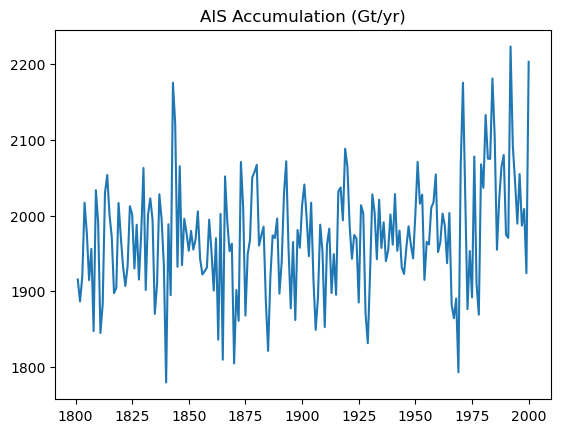

In [180]:
fullYears = np.arange(1801, 2001)
plt.plot(fullYears, ais_posterior_means, label='Posterior Mean')
plt.title('AIS Accumulation (Gt/yr)')

In [181]:
coeff = np.polyfit(fullYears[:], ais_posterior_means[:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[100:], ais_posterior_means[100:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[:100], ais_posterior_means[:100], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[100:156], ais_posterior_means[100:156], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[156:], ais_posterior_means[156:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(satYears[:22], ais_posterior_means[178:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

0.3272111518892194
0.9269507436690981
0.027218623977041452
0.40837776551040755
2.5619652398374044
-2.293285298294967


In [185]:
# Form the WAIS prior state vector by stacking:
# - RACMO WAIS-wide accumulation time series (first 42 yrs)
# - Bias-corrected RACMO-at-core locations (y_e)
# Resulting x_b has dimension: (1 + 84) × 42
x_b = np.vstack([wais_accum_racmo[:42], y_e]) 

# Prior mean across ensemble/time dimension for each state element
x_b_mean = np.mean(x_b, axis=1)

# Prior deviations from the mean (ensemble anomalies)
x_b_dev = x_b - x_b_mean[:, np.newaxis]

# Arrays to hold posterior WAIS reconstructions for 200 historical years (1801–2000)
wais_posterior_means = np.zeros(200)
wais_posterior_devs = np.zeros((200, 42))


# --- Ensemble Square-Root Kalman Filter (EnSRF) for WAIS reconstruction ---
for i in range(200):

    # Start assimilation for year i with the prior mean and deviations
    x_a_mean = np.copy(x_b_mean)   
    x_a_dev = np.copy(x_b_dev)

    # Loop through all 84 ice core observations
    for j in range(84):
        
        # Only assimilate if the proxy actually has a value in this year
        if not np.isnan(accumCoresFull[i, j]):
            
            # Mean and anomalies of the forward operator (bias-corrected RACMO at core j)
            y_e_mean = np.mean(y_e[j, :])
            y_e_dev = y_e[j, :] - y_e_mean

            # Covariance between state and observation (using ensemble anomalies)
            cov_term = (x_a_dev @ y_e_dev) / 41   # 41 = Ne−1 where Ne=42

            # Ensemble variance of the predicted observation
            var_term = np.var(y_e[j, :], ddof=1)

            # Kalman gain for the mean update
            kalman_gain_mean = cov_term / (var_term + R[j, j])

            # Update posterior mean using EnKF mean update formula
            x_a_mean = x_a_mean + kalman_gain_mean * (accumCoresFull[i, j] - y_e_mean)

            # Square-root update scalar (Whitaker & Hamill 2002 form)
            A = 1 / (1 + np.sqrt(R[j, j] / (var_term + R[j, j])))
            kalman_gain_dev = A * kalman_gain_mean

            # Update ensemble deviations (no noise inflation; deterministic EnSRF)
            x_a_dev = x_a_dev - np.outer(kalman_gain_dev, y_e_dev)

    # Store WAIS-wide posterior mean and ensemble spread for this reconstruction year
    wais_posterior_means[i] = x_a_mean[0]
    wais_posterior_devs[i, :] = x_a_dev[0, :]


Text(0.5, 1.0, 'WAIS Accumulation (Gt/yr)')

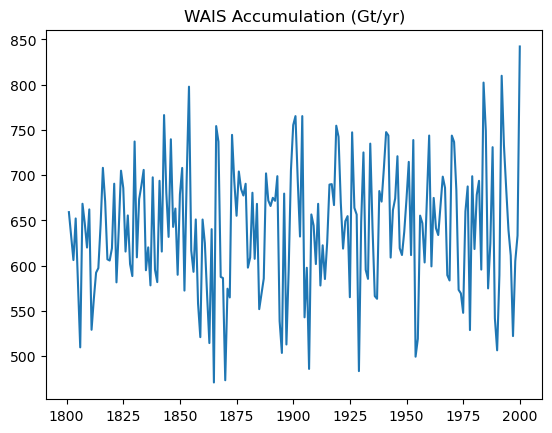

In [186]:
fullYears = np.arange(1801, 2001)
plt.plot(fullYears, wais_posterior_means, label='Posterior Mean')
plt.title('WAIS Accumulation (Gt/yr)')

In [184]:
coeff = np.polyfit(fullYears[:], wais_posterior_means[:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[100:], wais_posterior_means[100:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[:100], wais_posterior_means[:100], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[100:156], wais_posterior_means[100:156], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[156:], wais_posterior_means[156:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(satYears[:22], wais_posterior_means[178:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

0.12197623556903667
0.04910520943256959
0.05747889067666937
-0.0573681618233098
0.08996216881454241
-0.6313845611121698


In [187]:
# Form the EAIS prior state vector by stacking:
# - RACMO eAIS-wide accumulation time series (first 42 yrs)
# - Bias-corrected RACMO-at-core locations (y_e)
# Resulting x_b has dimension: (1 + 84) × 42
x_b = np.vstack([eais_accum_racmo[:42], y_e]) 

# Prior mean across ensemble/time dimension for each state element
x_b_mean = np.mean(x_b, axis=1)

# Prior deviations from the mean (ensemble anomalies)
x_b_dev = x_b - x_b_mean[:, np.newaxis]

# Arrays to hold posterior EAIS reconstructions for 200 historical years (1801–2000)
eais_posterior_means = np.zeros(200)
eais_posterior_devs = np.zeros((200, 42))


# --- Ensemble Square-Root Kalman Filter (EnSRF) for EAIS reconstruction ---
for i in range(200):

    # Start assimilation for year i with the prior mean and deviations
    x_a_mean = np.copy(x_b_mean)   
    x_a_dev = np.copy(x_b_dev)

    # Loop through all 84 ice core observations
    for j in range(84):
        
        # Only assimilate if the proxy actually has a value in this year
        if not np.isnan(accumCoresFull[i, j]):
            
            # Mean and anomalies of the forward operator (bias-corrected RACMO at core j)
            y_e_mean = np.mean(y_e[j, :])
            y_e_dev = y_e[j, :] - y_e_mean

            # Covariance between state and observation (using ensemble anomalies)
            cov_term = (x_a_dev @ y_e_dev) / 41   # 41 = Ne−1 where Ne=42

            # Ensemble variance of the predicted observation
            var_term = np.var(y_e[j, :], ddof=1)

            # Kalman gain for the mean update
            kalman_gain_mean = cov_term / (var_term + R[j, j])

            # Update posterior mean using EnKF mean update formula
            x_a_mean = x_a_mean + kalman_gain_mean * (accumCoresFull[i, j] - y_e_mean)

            # Square-root update scalar (Whitaker & Hamill 2002 form)
            A = 1 / (1 + np.sqrt(R[j, j] / (var_term + R[j, j])))
            kalman_gain_dev = A * kalman_gain_mean

            # Update ensemble deviations (no noise inflation; deterministic EnSRF)
            x_a_dev = x_a_dev - np.outer(kalman_gain_dev, y_e_dev)

    # Store EAIS-wide posterior mean and ensemble spread for this reconstruction year
    eais_posterior_means[i] = x_a_mean[0]
    eais_posterior_devs[i, :] = x_a_dev[0, :]


Text(0.5, 1.0, 'EAIS Accumulation (Gt/yr)')

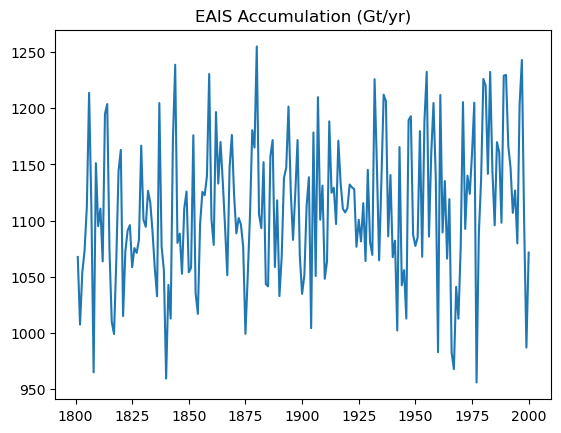

In [188]:
fullYears = np.arange(1801, 2001)
plt.plot(fullYears, eais_posterior_means, label='Posterior Mean')
plt.title('EAIS Accumulation (Gt/yr)')

In [189]:
coeff = np.polyfit(fullYears[:], eais_posterior_means[:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[100:], eais_posterior_means[100:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[:100], eais_posterior_means[:100], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[100:156], eais_posterior_means[100:156], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[156:], eais_posterior_means[156:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(satYears[:22], eais_posterior_means[178:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

0.20740389574021748
0.27602042585402814
0.3467699620354218
0.2322354823057095
1.0837641359539798
-4.271402971947152


In [191]:
# Form the AP prior state vector by stacking:
# - RACMO ap-wide accumulation time series (first 42 yrs)
# - Bias-corrected RACMO-at-core locations (y_e)
# Resulting x_b has dimension: (1 + 84) × 42
x_b = np.vstack([ap_accum_racmo[:42], y_e]) 

# Prior mean across ensemble/time dimension for each state element
x_b_mean = np.mean(x_b, axis=1)

# Prior deviations from the mean (ensemble anomalies)
x_b_dev = x_b - x_b_mean[:, np.newaxis]

# Arrays to hold posterior AP reconstructions for 200 historical years (1801–2000)
ap_posterior_means = np.zeros(200)
ap_posterior_devs = np.zeros((200, 42))


# --- Ensemble Square-Root Kalman Filter (EnSRF) for AP reconstruction ---
for i in range(200):

    # Start assimilation for year i with the prior mean and deviations
    x_a_mean = np.copy(x_b_mean)   
    x_a_dev = np.copy(x_b_dev)

    # Loop through all 84 ice core observations
    for j in range(84):
        
        # Only assimilate if the proxy actually has a value in this year
        if not np.isnan(accumCoresFull[i, j]):
            
            # Mean and anomalies of the forward operator (bias-corrected RACMO at core j)
            y_e_mean = np.mean(y_e[j, :])
            y_e_dev = y_e[j, :] - y_e_mean

            # Covariance between state and observation (using ensemble anomalies)
            cov_term = (x_a_dev @ y_e_dev) / 41   # 41 = Ne−1 where Ne=42

            # Ensemble variance of the predicted observation
            var_term = np.var(y_e[j, :], ddof=1)

            # Kalman gain for the mean update
            kalman_gain_mean = cov_term / (var_term + R[j, j])

            # Update posterior mean using EnKF mean update formula
            x_a_mean = x_a_mean + kalman_gain_mean * (accumCoresFull[i, j] - y_e_mean)

            # Square-root update scalar (Whitaker & Hamill 2002 form)
            A = 1 / (1 + np.sqrt(R[j, j] / (var_term + R[j, j])))
            kalman_gain_dev = A * kalman_gain_mean

            # Update ensemble deviations (no noise inflation; deterministic EnSRF)
            x_a_dev = x_a_dev - np.outer(kalman_gain_dev, y_e_dev)

    # Store AP-wide posterior mean and ensemble spread for this reconstruction year
    ap_posterior_means[i] = x_a_mean[0]
    ap_posterior_devs[i, :] = x_a_dev[0, :]


Text(0.5, 1.0, 'AP Accumulation (Gt/yr)')

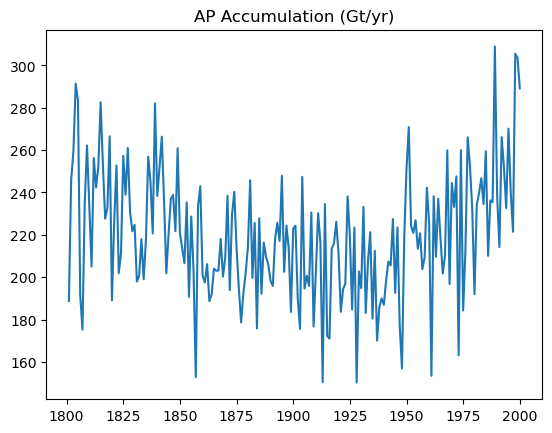

In [192]:
fullYears = np.arange(1801, 2001)
plt.plot(fullYears, ap_posterior_means, label='Posterior Mean')
plt.title('AP Accumulation (Gt/yr)')

In [193]:
coeff = np.polyfit(fullYears[:], ap_posterior_means[:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[100:], ap_posterior_means[100:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[:100], ap_posterior_means[:100], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[100:156], ap_posterior_means[100:156], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(fullYears[156:], ap_posterior_means[156:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

coeff = np.polyfit(satYears[:22], ap_posterior_means[178:], 1)  # coeff[0] = slope, coeff[1] = intercept
slope, intercept = coeff

print(slope)

-0.002168979420035389
0.6018251083824944
-0.37703022873504727
0.2335104450280057
1.3882389350688717
2.609502234764443


In [195]:
# Compute 19th-century means for each region (baseline = 1801–1900)
ais_mean_19th  = np.mean(ais_posterior_means[0:100])
wais_mean_19th = np.mean(wais_posterior_means[0:100])
eais_mean_19th = np.mean(eais_posterior_means[0:100])
ap_mean_19th   = np.mean(ap_posterior_means[0:100])

# Convert reconstruction to anomalies relative to 19th-century mean
# (i.e., excess accumulation in Gt/yr)
ais_anomaly  = ais_posterior_means  - ais_mean_19th
wais_anomaly = wais_posterior_means - wais_mean_19th
eais_anomaly = eais_posterior_means - eais_mean_19th
ap_anomaly   = ap_posterior_means   - ap_mean_19th

# Cumulative integral of SMB anomaly (Gt/yr) from 1801 onward.
# Dividing by 361.8 converts Gt → mm global-mean sea level equivalent.
# (361.8 Gt of ice ≈ 1 mm GMSL change)
ais_cumulative_integral  = np.cumsum(ais_anomaly)  / 361.8
wais_cumulative_integral = np.cumsum(wais_anomaly) / 361.8
eais_cumulative_integral = np.cumsum(eais_anomaly) / 361.8
ap_cumulative_integral   = np.cumsum(ap_anomaly)   / 361.8


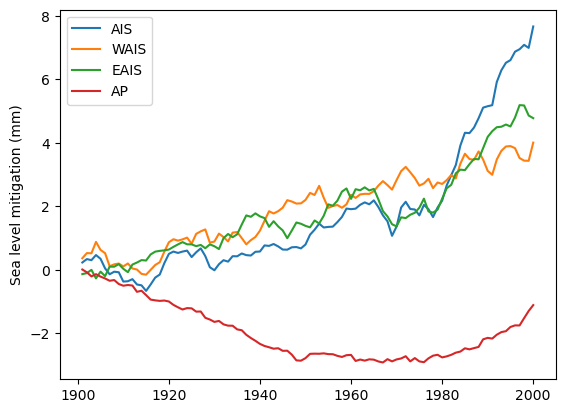

In [196]:
centYears = np.arange(1901, 2001)

plt.plot(centYears, ais_cumulative_integral[100:], label='AIS')
plt.plot(centYears, wais_cumulative_integral[100:], label='WAIS')
plt.plot(centYears, eais_cumulative_integral[100:], label='EAIS')
plt.plot(centYears, ap_cumulative_integral[100:], label='AP')
plt.ylabel('Sea level mitigation (mm)')

plt.legend()

In [198]:
# Printing the cumulative sea level mitigation for the 20th century
print(ais_cumulative_integral[199])
print(wais_cumulative_integral[199])
print(eais_cumulative_integral[199])
print(ap_cumulative_integral[199])

7.663303031942188
4.004109303510082
4.774560421466503
-1.115366693034249
